In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd

In [31]:
import datetime as dt

Reflect Tables into SQLAlchemy ORM

In [32]:
 # Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite") 

In [34]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [35]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [36]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

Exploratory Climate Analysis

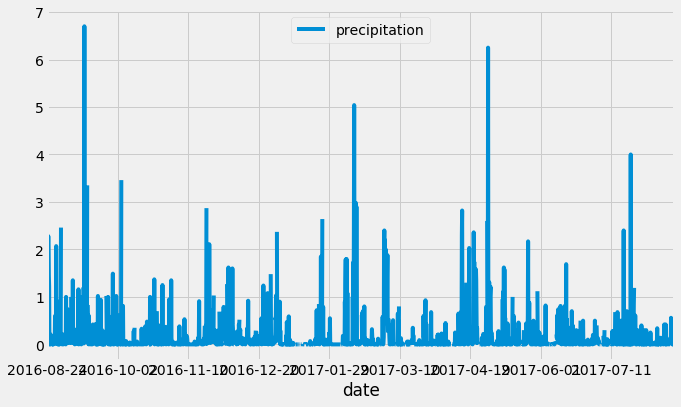

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

query_date_last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
date_full_year = dt.datetime.strptime(query_date_last, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

prcp_last12mon = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>=date_full_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_last12mon_df = pd.DataFrame(prcp_last12mon)

prcp_last12mon_df.set_index("date", inplace=True)
prcp_last12mon_df.rename(columns={"prcp":"precipitation"},inplace=True)

# Sort the dataframe by date

prcp_last12mon_df.sort_values(by="date",ascending=True,inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
prcp_last12mon_df.plot(figsize=(10,6))
plt.legend(loc="upper center")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last12mon_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
query_stations = session.query(Measurement.station).distinct().count()
query_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query_stations_activity = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
query_stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.

most_active_station=query_stations_activity[0][0]
most_active_high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

print(f"Most Active Station: {most_active_station}")
print(f"Low: {most_active_low} High: {most_active_high} Average: {most_active_avg}")

Most Active Station: USC00519281
Low: [(54.0,)] High: [(85.0,)] Average: [(71.66378066378067,)]


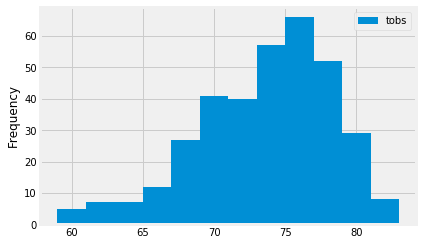

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# date_full_year = dt.datetime.strptime(query_date_last, "%Y-%m-%d") - dt.timedelta(days=365)


temp_last12mon = session.query(Measurement.tobs).filter(Measurement.date>=date_full_year).\
    filter(Measurement.station == "USC00519281").all()

temp_last12mon_df = pd.DataFrame(temp_last12mon)
temp_last12mon_df.plot.hist(bins=12)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2016-05-01', '2016-05-05')
print(trip_data)

[(68.0, 74.6470588235294, 79.0)]


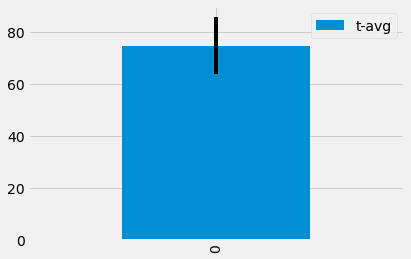

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data_df = pd.DataFrame(trip_data, columns = ['t-min', 't-avg', 't-max'])

trip_data_df.plot.bar(y='t-avg', yerr=(trip_data_df['t-max'] - trip_data_df['t-min']))

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation